In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
from typing import List

from xenium_cluster import XeniumCluster

In [2]:
CURRENT_SPOT_SIZE = 10
THIRD_DIM = True

In [3]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

In [4]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")

In [5]:
clustering.set_spot_size(CURRENT_SPOT_SIZE)

In [6]:
clustering.create_spot_data(third_dim=THIRD_DIM, save_data=True)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
# NORMALIZE THE COUNTS
clustering.normalize_counts(clustering.xenium_spot_data)

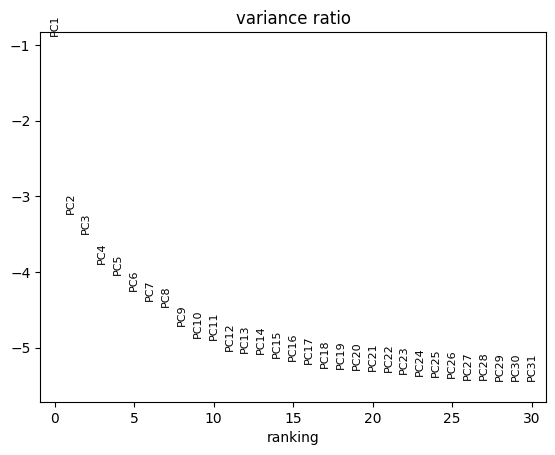

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
clustering.generate_neighborhood_graph(clustering.xenium_spot_data)

In [9]:
clustering.Leiden(clustering.xenium_spot_data, [0.05, 0.25, 1.0, 2.0], embedding="umap")